In [ ]:
!pip install xgboost lightgbm


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('OneDrive/Desktop/train.csv')
test = pd.read_csv('OneDrive/Desktop/test.csv')

In [3]:
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")


Train shape: (9021, 98)
Test shape: (10, 99)


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9021 entries, 0 to 9020
Data columns (total 98 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   date_id                        9021 non-null   int64  
 1   D1                             9021 non-null   int64  
 2   D2                             9021 non-null   int64  
 3   D3                             9021 non-null   int64  
 4   D4                             9021 non-null   int64  
 5   D5                             9021 non-null   int64  
 6   D6                             9021 non-null   int64  
 7   D7                             9021 non-null   int64  
 8   D8                             9021 non-null   int64  
 9   D9                             9021 non-null   int64  
 10  E1                             7237 non-null   float64
 11  E10                            8015 non-null   float64
 12  E11                            8015 non-null   f

In [5]:
train.columns

Index(['date_id', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'E1',
       'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19',
       'E2', 'E20', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'I1', 'I2', 'I3',
       'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'M1', 'M10', 'M11', 'M12', 'M13',
       'M14', 'M15', 'M16', 'M17', 'M18', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7',
       'M8', 'M9', 'P1', 'P10', 'P11', 'P12', 'P13', 'P2', 'P3', 'P4', 'P5',
       'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S11', 'S12', 'S2', 'S3', 'S4',
       'S5', 'S6', 'S7', 'S8', 'S9', 'V1', 'V10', 'V11', 'V12', 'V13', 'V2',
       'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'forward_returns',
       'risk_free_rate', 'market_forward_excess_returns'],
      dtype='object')

| Feature Group                       | Meaning                                | Description                                                                               |
| ----------------------------------- | -------------------------------------- | ----------------------------------------------------------------------------------------- |
| **`date_id`**                       | Trading Day Identifier                 | Unique ID for each trading day. Used for sorting, indexing, and time-based splits.        |
| **M***                              | Market Dynamics / Technical Indicators | Price/volume behavior, breadth indicators, moving averages, technical trend signals, etc. |
| **E***                              | Macro-Economic Indicators              | GDP growth, unemployment, inflation proxies, global macro conditions.                     |
| **I***                              | Interest Rate Features                 | Federal funds rate, Treasury yields, yield spreads, monetary policy indicators.           |
| **P***                              | Price / Valuation Metrics              | P/E ratio, earnings yield, dividend yield, CAPE-style measures, valuation ratios.         |
| **V***                              | Volatility Features                    | VIX index, realized volatility, rolling historical volatility.                            |
| **S***                              | Sentiment Features                     | Investor sentiment: news sentiment, surveys, options sentiment, risk appetite.            |
| **MOM***                            | Momentum Features                      | 1-month, 3-month, 12-month return momentum, RSI, technical momentum signals.              |
| **D***                              | Dummy / Binary Indicators              | Day of week, holiday flags, quarter-end/month-end, special event flags.                   |
| **`forward_returns`**               | Next-Day Returns                       | Actual 1-day forward S&P 500 return (train only).                                         |
| **`risk_free_rate`**                | Risk-Free Rate                         | Short-term interest rate (Fed Funds). Train only.                                         |
| **`market_forward_excess_returns`** | **Target Variable**                    | Forward return minus rolling 5-year mean, winsorized using MAD(4). Train only.            |


In [6]:
pd.set_option('display.max_columns', None)
train.head(20)


,date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,E1,E10,E11,E12,E13,E14,E15,E16,E17,E18,E19,E2,E20,E3,E4,E5,E6,E7,E8,E9,I1,I2,I3,I4,I5,I6,I7,I8,I9,M1,M10,M11,M12,M13,M14,M15,M16,M17,M18,M2,M3,M4,M5,M6,M7,M8,M9,P1,P10,P11,P12,P13,P2,P3,P4,P5,P6,P7,P8,P9,S1,S10,S11,S12,S2,S3,S4,S5,S6,S7,S8,S9,V1,V10,V11,V12,V13,V2,V3,V4,V5,V6,V7,V8,V9,forward_returns,risk_free_rate,market_forward_excess_returns
0,0,0,0,0,1,1,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002421,0.000301,-0.003038
1,1,0,0,0,1,1,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.008495,0.000303,-0.009114
2,2,0,0,0,1,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.009624,0.000301,-0.010243
3,3,0,0,0,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004662,0.000299,0.004046
4,4,0,0,0,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.011686,0.000299,-0.012301
5,5,0,0,0,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.006449,0.000300,-0.007066
6,6,0,0,0,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003644,0.000298,0.003029
7,7,0,0,0,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.024566,0.000300,-0.025183
8,8,0,0,0,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.008492,0.000298,-0.009105
9,9,0,0,0,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [9]:
train['forward_returns'].describe()

count    9021.000000
mean        0.000471
std         0.010541
min        -0.039754
25%        -0.004319
50%         0.000659
75%         0.005896
max         0.040661
Name: forward_returns, dtype: float64

In [10]:
test.head(10)

,date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,E1,E10,E11,E12,E13,E14,E15,E16,E17,E18,E19,E2,E20,E3,E4,E5,E6,E7,E8,E9,I1,I2,I3,I4,I5,I6,I7,I8,I9,M1,M10,M11,M12,M13,M14,M15,M16,M17,M18,M2,M3,M4,M5,M6,M7,M8,M9,P1,P10,P11,P12,P13,P2,P3,P4,P5,P6,P7,P8,P9,S1,S10,S11,S12,S2,S3,S4,S5,S6,S7,S8,S9,V1,V10,V11,V12,V13,V2,V3,V4,V5,V6,V7,V8,V9,is_scored,lagged_forward_returns,lagged_risk_free_rate,lagged_market_forward_excess_returns
0,8980,0,0,0,0,1,0,0,1,0,1.577651,0.186177,0.001323,0.001323,0.001323,0.001323,0.955026,-0.583419,-0.704264,0.298365,-0.691361,1.259065,1.556516,1.712580,0.033069,0.333333,0.036376,-0.046483,-0.312326,0.913029,0.306217,1.025756,0.081349,0.478175,0.675627,0.699735,0.256283,0.360450,0.676061,-1.310438,-0.392342,-0.236100,0.169554,-1.196419,-0.760030,0.641204,0.916667,0.289683,0.318783,-0.321981,3.394801,0.110939,0.755237,-0.318948,-0.596875,0.867394,0.348006,0.470569,2.113675,2.247820,0.882724,0.794643,-1.427834,0.352513,0.926257,0.431383,-0.476976,0.500245,1.784173,0.029762,0.294719,0.514550,0.446429,0.466551,0.085717,-0.230132,0.272487,-0.106894,0.199735,0.409392,0.532717,0.744048,0.440476,-0.654839,0.699735,0.699074,-0.502400,0.882937,0.892196,0.828042,0.999172,0.759921,-0.803127,0.170966,-0.751909,True,0.003541,0.000161,0.003068
1,8981,0,0,0,0,1,0,0,1,0,1.575182,0.185847,0.000992,0.000992,0.000992,0.000992,0.955357,-0.583074,-0.703759,0.297608,-0.504499,1.193468,1.554184,1.640054,0.032738,0.333003,0.036045,0.073582,-0.312345,0.913360,0.305886,0.989571,0.082672,0.477844,0.661527,0.719577,0.255952,0.361111,0.660556,-1.234687,-0.357220,-0.220754,0.191398,-1.203526,-0.759527,0.641865,0.852513,0.289021,0.318452,0.380119,0.298001,0.010021,1.126653,-0.314881,-0.597245,0.961640,0.313527,0.331019,2.089552,2.199278,-0.428140,0.711310,-1.376520,0.953042,0.386905,0.523549,-0.421365,-0.234829,1.770175,0.033730,0.304496,0.638228,0.636905,1.849101,0.281690,-0.041995,0.448413,0.094321,0.215608,0.409392,0.597864,0.872354,0.691138,-0.583443,0.629960,0.598545,-0.394268,0.863757,0.699074,0.831349,1.120336,0.556217,-0.686192,0.141865,-0.660326,True,-0.005964,0.000162,-0.006437
2,8982,0,0,0,0,1,0,0,0,1,1.572720,0.185516,0.000661,0.000661,0.000661,0.000661,0.955688,-0.083356,-0.573546,0.225822,-0.393903,1.123361,1.551723,1.562722,0.032407,0.332672,0.035714,0.033581,-0.312364,0.913690,0.291997,1.040514,0.081349,0.477513,0.655741,0.724206,0.226190,0.355820,0.650325,-1.128989,-0.347297,-0.241044,0.199469,-1.189592,-0.757391,0.652116,0.879630,0.288360,0.318122,1.351334,0.391480,-0.233158,0.860735,-0.244248,-0.596983,0.513228,0.276338,0.348545,2.067406,2.149585,0.368688,0.212632,-1.347620,0.210979,0.635251,-1.138198,-0.494248,-1.042718,1.754171,0.032407,0.257609,0.082011,0.152116,-0.201611,0.346373,0.054032,0.137566,0.294305,0.194444,0.409392,0.596528,0.778439,0.634921,-0.483236,0.669974,0.603836,-0.170420,0.848545,0.647487,0.832672,1.088992,0.665344,-0.459367,0.199405,-0.510979,True,-0.007410,0.000160,-0.007882
3,8983,0,0,0,0,1,0,0,0,1,1.570266,0.185185,0.019841,0.019841,0.006614,0.006614,0.956019,-0.083403,-0.573180,0.225094,-0.541646,1.167982,1.549272,1.611215,0.032077,0.332341,0.035384,0.033998,-0.312383,0.914021,0.267196,1.091376,0.085979,0.477183,0.648582,0.728175,0.230159,0.351852,0.649528,-1.150431,-0.300917,-0.145171,0.269389,-1.165139,-0.754948,0.652116,0.853836,0.279431,0.317791,-0.212995,3.032725,0.024158,1.426994,-0.286942,-0.572019,0.681548,0.302134,0.309193,2.079415,2.175705,0.368943,0.660714,-1.399411,0.724868,0.216270,-0.230557,-0.318347,0.396917,1.769678,0.033730,0.202350,0.324074,0.212963,0.052878,-0.049023,0.120828,0.219577,0.137942,0.167328,0.409392,0.579726,0.449735,0.665344,-0.546298,0.590608,0.558862,-0.275099,0.826058,0.445767,0.835979,1.040988,0.594577,-0.561643,0.161706,-0.575997,True,0.005420,0.000160,0.004949
4,8984,0,0,0,0,0,0,1,0,1,1.567818,0.184854,0.019511,0.019511,0.006283,0.006283,0.956349,-0.083449,-0.572813,0.224366,-0.714549,1.243713,1.542543,1.693604,0.031746,0.332011,0.035053,0.029586,-0.301855,0.914352,0.2

In [11]:
print(f'avg_fr:',{train['forward_returns'].mean()})
print(f'avg_rrate:',{train['risk_free_rate'].mean()})
print(f'avg_market_return:',{train['market_forward_excess_returns'].mean()})

avg_fr: {0.0004714512565883775}
avg_rrate: {0.00010703611766544572}
avg_market_return: {5.3213773017774764e-05}


In [12]:
miss_value_perc = (train.isnull().mean()/train.shape[0])*10000

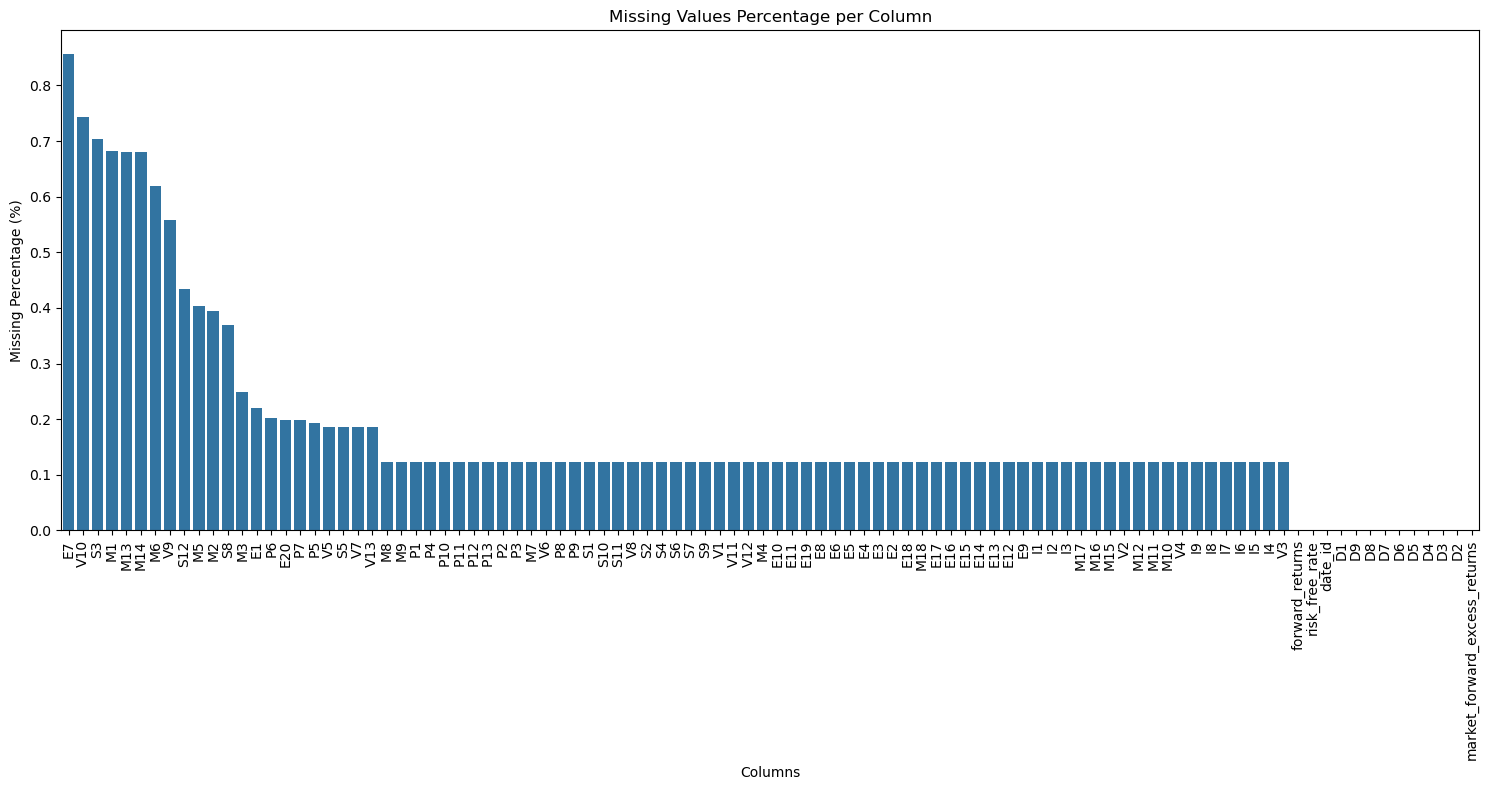

In [13]:
miss_value_perc_formatted = miss_value_perc.sort_values(ascending=False)
plt.figure(figsize=(15,8))
sns.barplot(x=miss_value_perc_formatted.index,y=miss_value_perc_formatted.values)

plt.xticks(rotation=90)
plt.xlabel("Columns")
plt.ylabel("Missing Percentage (%)")
plt.title("Missing Values Percentage per Column")

plt.tight_layout()
plt.show()


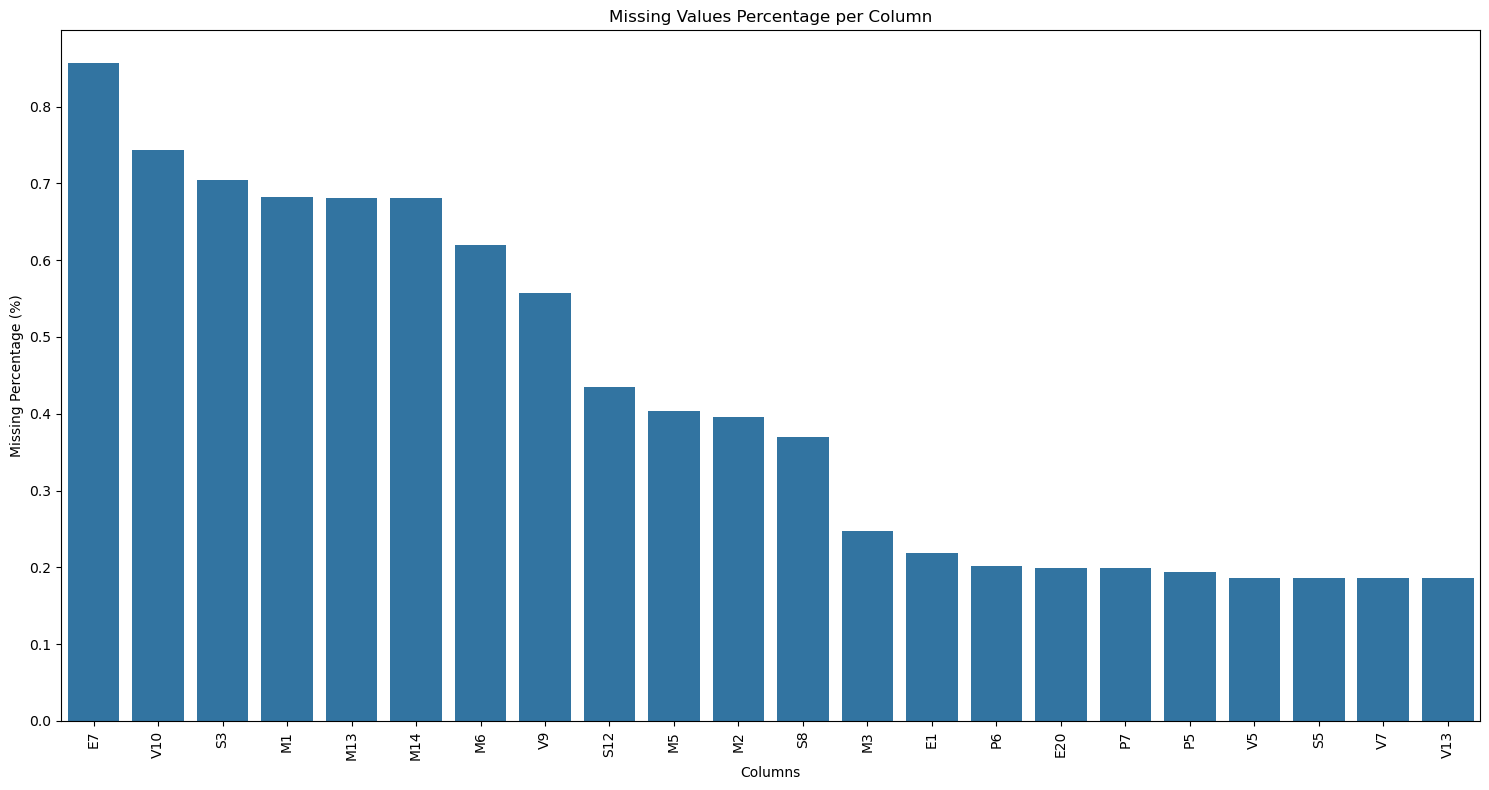

In [14]:
miss_value_perc11 = miss_value_perc_formatted[miss_value_perc_formatted>0.15]
plt.figure(figsize=(15,8))
sns.barplot(x=miss_value_perc11.index,y=miss_value_perc11.values)

plt.xticks(rotation=90)
plt.xlabel("Columns")
plt.ylabel("Missing Percentage (%)")
plt.title("Missing Values Percentage per Column")

plt.tight_layout()
plt.show()

In [22]:
train_target=train.loc[:,['market_forward_excess_returns']]

In [23]:
train_target

,market_forward_excess_returns
0,-0.003038
1,-0.009114
2,-0.010243
3,0.004046
4,-0.012301
...,...
9016,-0.000477
9017,-0.005661
9018,0.005467
9019,0.007710


In [25]:
train=train.drop(columns=['market_forward_excess_returns']).copy()

In [26]:
train.head(10)

,date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,E1,E10,E11,E12,E13,E14,E15,E16,E17,E18,E19,E2,E20,E3,E4,E5,E6,E7,E8,E9,I1,I2,I3,I4,I5,I6,I7,I8,I9,M1,M10,M11,M12,M13,M14,M15,M16,M17,M18,M2,M3,M4,M5,M6,M7,M8,M9,P1,P10,P11,P12,P13,P2,P3,P4,P5,P6,P7,P8,P9,S1,S10,S11,S12,S2,S3,S4,S5,S6,S7,S8,S9,V1,V10,V11,V12,V13,V2,V3,V4,V5,V6,V7,V8,V9,forward_returns,risk_free_rate
0,0,0,0,0,1,1,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002421,0.000301
1,1,0,0,0,1,1,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.008495,0.000303
2,2,0,0,0,1,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.009624,0.000301
3,3,0,0,0,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004662,0.000299
4,4,0,0,0,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.011686,0.000299
5,5,0,0,0,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.006449,0.000300
6,6,0,0,0,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003644,0.000298
7,7,0,0,0,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.024566,0.000300
8,8,0,0,0,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.008492,0.000298
9,9,0,0,0,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [27]:
train.fillna(0)

,date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,E1,E10,E11,E12,E13,E14,E15,E16,E17,E18,E19,E2,E20,E3,E4,E5,E6,E7,E8,E9,I1,I2,I3,I4,I5,I6,I7,I8,I9,M1,M10,M11,M12,M13,M14,M15,M16,M17,M18,M2,M3,M4,M5,M6,M7,M8,M9,P1,P10,P11,P12,P13,P2,P3,P4,P5,P6,P7,P8,P9,S1,S10,S11,S12,S2,S3,S4,S5,S6,S7,S8,S9,V1,V10,V11,V12,V13,V2,V3,V4,V5,V6,V7,V8,V9,forward_returns,risk_free_rate
0,0,0,0,0,1,1,0,0,0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.002421,0.000301
1,1,0,0,0,1,1,0,0,0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.008495,0.000303
2,2,0,0,0,1,0,0,0,0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.009624,0.000301
3,3,0,0,0,1,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004662,0.000299
4,4,0,0,0,1,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

In [32]:
x = train.copy()
y = train_target

from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, Y_train)

# Predictions
Y_pred_rf = rf.predict(X_test)

# RMSE
rf_rmse = (mean_squared_error(Y_test,Y_pred_rf))**0.5
print("Random Forest RMSE:", rf_rmse)


Random Forest RMSE: 7.15710144866886e-05


In [37]:
model = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42,
    tree_method="hist"     
)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred)
rmse = mse**0.5
r2 = r2_score(Y_test, Y_pred)

print("MSE:", mse)
print("RMSE:", rmse)
print("R² Score:", r2)




MSE: 1.9335463313508653e-07
RMSE: 0.0004397210856157418
R² Score: 0.9982350468635559
